# Predicting Salaries for MLB Players
**Kevin Payton**

**PSTAT 131 Fall 24**

---
## MLB Information
![](https://logonoid.com/images/mlb-logo.png)

### What is the MLB?

The MLB, or Major League Baseball, is a professional baseball league and the highest possible level of organized play for the USA and Canada. This organization has 30 different teams, split up between 2 different leagues, the American League and National League, and 3 divisions per league. Being founded in the late 19th century, the MLB has a very rich and long history.

### Player Salaries and Economics

MLB player salaries are a significant aspect of team operations and player management. Salaries are influenced by various factors, including a player's performance, experience, marketability, and the financial strategies of the franchise. Contracts can range from modest deals for emerging talents to multi-million-dollar agreements for star players. Teams utilize advanced metrics and statistical analyses to evaluate player contributions and determine fair compensation, balancing performance with budget constraints.

The economics of MLB are shaped by factors like team revenues, media rights deals, merchandise sales, and ticket sales. Player salaries contribute significantly to a team's payroll, impacting its competitive balance and financial health. The interplay between player performance metrics and compensation models is a focal point for both teams and analysts, aiming to optimize investment in talent while maintaining fiscal responsibility.

### What are we Trying to Predict?

For this project, I will be attempting to predict player's salaries based on various batting statistics and information about the player's themselves. 

---
## Loading our Data and Libraries

First import my libraries:

In [1]:
# Import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from aquarel import load_theme
import joblib
import cpi

And now read all my .csv files:

In [2]:
# Load all datasets
master = pd.read_csv('Master.csv')
salaries = pd.read_csv('Salaries.csv')
batting_stats = pd.read_csv('Batting.csv')
fielding = pd.read_csv('Fielding.csv')
war = pd.read_csv('jeffbagwell_war_historical.csv', encoding='latin-1')

Almost everything comes from Kaggle at the following link: https://www.kaggle.com/datasets/open-source-sports/baseball-databank?resource=download. I decided on using the Master.csv, Salaries.csv, Fielding.csv, and Batting.csv files which all have data from 1871 through 2015, but I will only be working with data from the year 1990 to 2015. The Master.csv file contains personal information of all the players in the dataset, but I will only be using this to gather the names of players to make importing any future data easier since currently my datasets rely on player IDs. The Salaries.csv file contains team and league information, as well as the salary players have for any given year. The Fielding.csv file contains various fielding statistics, but we only need this for a player's position. Finally, my Batting.csv file contains various batting statistics for players, most of which will be used as my predictors for the dependent variable salary.

The final csv file comes from the following github repository: https://github.com/Neil-Paine-1/MLB-WAR-data-historical. I am only using the jeffbagwell_war_historical.csv file since it contains all MLB player's WAR data since 1901. I will only be using the actual WAR column and not any of the other columns used in its calculation. WAR is a very important stat in modern baseball, so I figured it would be a great predictor for a player's salary.

---
## Exploring, Merging, and Tidying our Data

### Names and Salaries

Let's start messing with our data and see what needs to be fixed:

In [3]:
# Create a column for a player's full name
master['nameFull'] = master['nameFirst'] + ' ' + master['nameLast']
names = master[['playerID', 'nameFull', 'birthYear']]
# Finds amount of rows and columns for names data
print(names.shape)

# Remove all salary data prior to 1990
salaries_post_1990 = salaries[salaries['yearID'] >= 1990]
# Finds amount of rows and columns for salaries data
print(salaries_post_1990.loc[salaries_post_1990.yearID >= 1990].shape)

# Merge our salaries and names data on an inner join
merged_data = pd.merge(salaries_post_1990, names, on='playerID', how='inner')
# Finds amount of rows and columns for the merged data
print(merged_data.shape)

(18846, 3)
(22286, 5)
(22278, 7)


I first decided to make a full name column because the player's first and last names were separated in our Master.csv file. I then removed all columns except the `playerID` and `nameFull` to make the merging with salaries easier since all the other columns were unneeded. This left us with 18846 rows and 2 columns, with the rows each representing players. We are left with so many because we currently still have values from every player that has played since 1871 through 2015, but all those prior to 1990 will be removed once we merge with our salaries dataset. 

I then filtered out all player data from Salaries.csv prior to 1990 to simplify things, leaving us with 22286 rows and 5 columns containing simple data about a player, the team they started the season and its league, as well as the year and their salary. This file does not contain information on if a player was traded during the year, because their salary stays the same. This is an issue I might have later when dealing with the batting information, because there might be multiple rows for the same player during a given year.

I was then able to finally merge the two datasets together with an inner join and once again printed the shape. As you can see above, we were missing 8 player's names from the names data frame so I will create a function to discover the index of these players, as well as their `playerID` so I can try and find some more information about them in our Master.csv file.

In [4]:
# Store our left merged dataframe
merged_data_left = pd.merge(salaries_post_1990, names, on='playerID', how='left')

# Create a dataframe of boolean values for finding null values
null_data = merged_data_left['nameFull'].isnull()
missing_names = []

# Loop through our null data dataframe to find playerID's missing their full names
for ind in merged_data_left.index:
    if null_data.iloc[ind] == True:
        missing_names.append(merged_data_left.loc[ind, 'playerID'])

# Print all playerID's found
print(missing_names)

['harriwi10', 'castiru02', 'rosajo01', 'arrueba01', 'furcara02', 'castiru02', 'rosajo01', 'harriwi10']


It seems like we have 5 unique incorrect `playerID`s that were missing information in our Master.csv file but were in our Salaries.csv file. First let's simply just try to loop through Master.csv and see if there is any information in it.

In [5]:
# Loop through our master file to find each playerID
for playerid in missing_names:
    print(master.loc[master['playerID'] == playerid])

Empty DataFrame
Columns: [playerID, birthYear, birthMonth, birthDay, birthCountry, birthState, birthCity, deathYear, deathMonth, deathDay, deathCountry, deathState, deathCity, nameFirst, nameLast, nameGiven, weight, height, bats, throws, debut, finalGame, retroID, bbrefID, nameFull]
Index: []

[0 rows x 25 columns]
Empty DataFrame
Columns: [playerID, birthYear, birthMonth, birthDay, birthCountry, birthState, birthCity, deathYear, deathMonth, deathDay, deathCountry, deathState, deathCity, nameFirst, nameLast, nameGiven, weight, height, bats, throws, debut, finalGame, retroID, bbrefID, nameFull]
Index: []

[0 rows x 25 columns]
Empty DataFrame
Columns: [playerID, birthYear, birthMonth, birthDay, birthCountry, birthState, birthCity, deathYear, deathMonth, deathDay, deathCountry, deathState, deathCity, nameFirst, nameLast, nameGiven, weight, height, bats, throws, debut, finalGame, retroID, bbrefID, nameFull]
Index: []

[0 rows x 25 columns]
Empty DataFrame
Columns: [playerID, birthYear, bi

Unfortunately, I was unable to find these names simply from going through the file, so I will have to do some extra research in case the ID was simply input wrong.

I was first able to discover that the player with the ID 'harriwi10' was Will Harris and was given the ID 'harriwi02' in both Master.csv and Batting.csv. The player with the ID 'castiru02' was Rusney Castillo with the ID 'castiru01'. The player with the ID 'rosajo01' was Jorge De La Rosa and also had data under the ID 'delarjo01'. The player with the ID 'arrueba01' was Erisbel Arruebarrena who also had data under the ID 'arrueer01'. Finally, the player with the ID 'furcara02' was Rafael Furcal who also had data under 'furcara01'.

In [6]:
# Manually change each playerID in our salaries dataframe
salaries_post_1990.loc[salaries_post_1990.playerID == 'harriwi10', 'playerID'] = 'harriwi02'
salaries_post_1990.loc[salaries_post_1990.playerID == 'castiru02', 'playerID'] = 'castiru01'
salaries_post_1990.loc[salaries_post_1990.playerID == 'rosajo01', 'playerID'] = 'delarjo01'
salaries_post_1990.loc[salaries_post_1990.playerID == 'arrueba01', 'playerID'] = 'arrueer01'
salaries_post_1990.loc[salaries_post_1990.playerID == 'furcara02', 'playerID'] = 'furcara01'

In [7]:
# Merge the salaries and names dataframes
final_merged_data = pd.merge(salaries_post_1990, names, on='playerID', how='inner')

I think adding age might be a good predictor for our models since typically the higher paid players are slightly older because they've been playing longer. Much younger players are likely rookies and typically have smaller salaries even if they're stars.

In [8]:
# Create an age column and drop birthYear
final_merged_data['age'] = final_merged_data['yearID'] - final_merged_data['birthYear']
final_merged_data = final_merged_data.drop('birthYear', axis=1)

### Batting Stats

Now the set of data containg the player names and salaries should be all cleaned up and ready, so we just need to work on the batting stats and getting everything merged together.

In [9]:
# Remove all batting stats prior to 1990
batting_stats = batting_stats[batting_stats['yearID'] >= 1990]

# Print the shape and null values of our batting dataframe
print(batting_stats.shape)
print(batting_stats.isnull().sum())

(33924, 22)
playerID       0
yearID         0
stint          0
teamID         0
lgID           0
G              0
AB          2049
R           2049
H           2049
2B          2049
3B          2049
HR          2049
RBI         2049
SB          2049
CS          2049
BB          2049
SO          2049
IBB         2049
HBP         2049
SH          2049
SF          2049
GIDP        2049
dtype: int64


In [10]:
# Drop all rows with no at bats
batting_stats.dropna(subset=['AB'], inplace=True)

We had a lot of null values for our batting stats, presumably for players who were pitchers and weren't required to bat, so I removed all of those. This will make it easier to work with our data. Since we have so many more rows in our batting dataframe, 33924, than our salaries and names dataframe, 22286, we clearly have a lot of players with multiple rows of stats for a given year. All I need to do is combine the rows for players who were traded during the season, since all their stats are countable.

In [11]:
# Get all the names of the stats we are grouping
stats = ['G','AB','R','H','2B','3B','HR','RBI','SB','CS','BB','SO','IBB','HBP','SH','SF','GIDP']

# Group together by playerID and yearID and sum the stats
new_batting = batting_stats.groupby(['playerID', 'yearID'])[stats].sum().reset_index()

# Merge the batting, names, and salaries data frames and print the shape
new_merged = pd.merge(new_batting, final_merged_data, on=['playerID', 'yearID'], how='inner')
print(new_merged.shape)

(20337, 24)


### Positions

Now all our batting data is grouped together by year and player and we were able to merge our data sets together, leaving us with 20337 rows and 24 columns. Now we can add all the positions to remove pitchers because they should not be judged based on their battings stats.

In [12]:
# Create new dataframe containing only the columns we want past the year 1989
new_fielding = fielding[['playerID', 'yearID', 'POS', 'G']]
new_fielding = new_fielding[new_fielding['yearID'] >= 1990]

# Groupby playerID, yearID, and POS and sum all the games
fielding_counts = new_fielding.groupby(['playerID', 'yearID', 'POS'])['G'].sum().reset_index()

# Sort by the summed up games and drop all duplicate columns to get the most played position
fielding_counts.sort_values(by=['playerID','yearID','G'], ascending=False, inplace=True)
fielding_counts.drop_duplicates(subset=['playerID', 'yearID'], keep='first', inplace=True)
fielding_counts.drop('G', axis=1, inplace=True)

Due to the fact that players can play multiple positions in a given season, to add the position data I first had to sum up all the games played for a specific positon for each given year for each player. I was then able to sort these new values and drop all the rows for positions that weren't the most played for every player. I then finally removed our games played column because all we wanted was every player's most played position.

In [13]:
# Complete another merge now including the position data
pos_merge = pd.merge(fielding_counts, new_merged, on=['playerID', 'yearID'], how='inner')
pos_merge_no_pitchers = pos_merge[pos_merge.POS != 'P']

### WAR

After merging that data together, I also removed all pitchers since they should not be judged purely on their batting stats. Now we can work with our final dataframe to merge, WAR.

In [14]:
# Reduce columns to only those we need
war = war[['key_bbref','year_ID','WAR162']]

# Rename our columns for our merge
war.rename(columns={'key_bbref' : 'playerID', 'year_ID' : 'yearID', 'WAR162' : 'WAR'}, inplace=True)

# Only keep the years we need and drop any repeated columns
war = war.loc[(war.yearID >= 1990) & (war.yearID <= 2015)]
war = war.drop_duplicates()

# Sum all WAR values for players who were traded during the season
war = war.groupby(by=['playerID', 'yearID'])['WAR'].sum().reset_index()

### Finishing Touches

To finish it off we can simply merge everything together, and reorganize our columns.

In [15]:
# Perform our final merge and reorder the columns
final_merge = pd.merge(pos_merge_no_pitchers, war, on=['playerID', 'yearID'], how='inner')
final_data = final_merge[['playerID', 'nameFull', 'yearID', 'POS', 'salary', 'teamID',
                        'age', 'lgID', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS',
                        'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'WAR']]
print(final_data.shape)
print(final_data.columns)

(11241, 26)
Index(['playerID', 'nameFull', 'yearID', 'POS', 'salary', 'teamID', 'age',
       'lgID', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB',
       'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'WAR'],
      dtype='object')


We are finally left with 11241 rows and 26 columns containing batting and salary information about most MLB players from 1990 to 2015.

In [16]:
# Change our categorical columns to have that datatype
final_data['POS'] = final_data['POS'].astype('category')
final_data['lgID'] = final_data['lgID'].astype('category')
final_data['teamID'] = final_data['teamID'].astype('category')

In [17]:
# Only keep players with 20 or more games played
final_data = final_data[final_data.G >= 20]

I also decided to remove all player data for those who played less than 20 games, because they might skew our model if they have high salaries and low stats.

For some reason we also have a player with a salary value of $0, so I will go manually find the real value and fix that.

In [18]:
# Manually change salary
final_data.loc[final_data.playerID == 'jamesdi01', 'salary'] = 109000

### Adjusted Salary

Although we are including year as a feature for our model, I am curious how all the predictions would be if we were to adjust all salaries for inflation to what they would be like at present time, or rather in 2023 since we don't have values for 2024. Rather than inflating it to 2015 standards, our largest year, I would like to see if the best models still hold up for modern players. To do this I will simply import the Consumer Price Index to adjust the salaries accordingly.

In [19]:
# Create a dataframe containing the CPI index for all our years
all_years = final_data['yearID'].unique()
cpi_list = []
years_list = []
for year in all_years:
    cpi_list.append(cpi.inflate(1.0, year))
    years_list.append(year)
df_years = pd.DataFrame({'yearID' : years_list, 'cpi' : cpi_list}).sort_values(by='yearID', axis=0)

# Merge our finalized data and CPI information
final_data = pd.merge(final_data, df_years, on='yearID', how='inner')

# Calculate our adjusted salaries and drop the CPI values
final_data['adjusted_salary'] = final_data['salary'] * final_data['cpi']
final_data.drop('cpi', axis=1, inplace=True)

To ensure that my models won't output any negative salaries, we will transform our `salary` and `adjusted_salary` columns to instead hold the `ln(salary)` and `ln(adjusted_salary)`, because then even if we are given a negative value, when inversing the natural log it will always result in a positive number. This should also reduce the variance and skewness of our distribution, as this is a very typical method to deal with this sort of issue.

In [20]:
# log base e transform our dependent variable column
final_data['salary'] = np.log(final_data['salary'])
final_data['adjusted_salary'] = np.log(final_data['adjusted_salary'])

---
## Exploratory Data Analysis

Now, we will explore the relationships between all our variables! First let's load a theme to make our graphs look fancy.

In [21]:
# Load and apply a dark theme for seaborn
theme = load_theme('umbra_dark')
theme.apply()

We'll first simply look at a summary of basic statistics for each of our variables.

In [22]:
# Output five number summary, mean, and standard deviation
final_data.describe()

,yearID,salary,age,G,AB,R,H,2B,3B,HR,...,CS,BB,SO,IBB,HBP,SH,SF,GIDP,WAR,adjusted_salary
count,10575.000000,10575.000000,10575.000000,10575.000000,10575.000000,10575.000000,10575.000000,10575.000000,10575.000000,10575.000000,...,10575.000000,10575.000000,10575.000000,10575.000000,10575.000000,10575.000000,10575.000000,10575.000000,10575.000000,10575.000000
mean,2002.346478,13.833984,29.699385,104.823830,339.780236,46.944681,91.100047,17.880095,1.926619,10.433759,...,2.790544,33.803593,62.622222,2.804444,3.284444,2.082648,2.943168,7.819385,1.325561,14.352136
std,7.424626,1.377284,4.039400,39.905026,176.912641,30.327627,53.292765,11.558700,2.302930,10.150221,...,3.290187,24.568404,36.803089,4.197322,3.566870,2.962820,2.518118,5.524513,1.985748,1.320761
min,1990.000000,11.512925,19.000000,20.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.180000,12.244720
25%,1996.000000,12.765688,27.000000,74.000000,181.000000,21.000000,44.000000,8.000000,0.000000,3.000000,...,0.000000,14.000000,33.000000,0.000000,1.000000,0.000000,1.000000,3.000000,-0.110000,13.246225
50%,2002.000000,13.592367,29.000000,110.000000,340.000000,42.000000,87.000000,16.000000,1.000000,7.000000,...,2.000000,28.000000,57.000000,1.000000,2.000000,1.000000,2.000000,7.000000,0.765000,14.126424
75%,2009.000000,14.968190,32.000000,140.000000,497.500000,70.000000,136.000000,26.000000,3.000000,15.000000,...,4.000000,48.000000,87.000000,4.000000,5.000000,3.000000,4.000000,11.000000,2.325000,15.487834
max,2015.000000,17.312018,49.000000,163.000000,716.000000,152.000000,262.000000,59.000000,23.000000,73.000000,...,28.000000,232.000000,223.000000,120.000000,34.000000,39.000000,17.000000,32.000000,12.225000,17.662870


Let's also make sure we don't have any missing data before we continue.

In [23]:
# Print all null values
print(final_data.isnull().sum())

playerID           0
nameFull           0
yearID             0
POS                0
salary             0
teamID             0
age                0
lgID               0
G                  0
AB                 0
R                  0
H                  0
2B                 0
3B                 0
HR                 0
RBI                0
SB                 0
CS                 0
BB                 0
SO                 0
IBB                0
HBP                0
SH                 0
SF                 0
GIDP               0
WAR                0
adjusted_salary    0
dtype: int64


### Correlation Plot

Now let's make a correlation matrix with all our continuous numerical variables (`yearID`, `salary`, `G`, `AB`, `R`, `H`, `2B`, `3B`, `HR`, `RBI`, `SB`, `CS`, `BB`, `SO`, `IBB`, `HBP`, `SH`, `SF`, `GIDP`, `adjusted_salary`) to see how they are correlated with each other. 

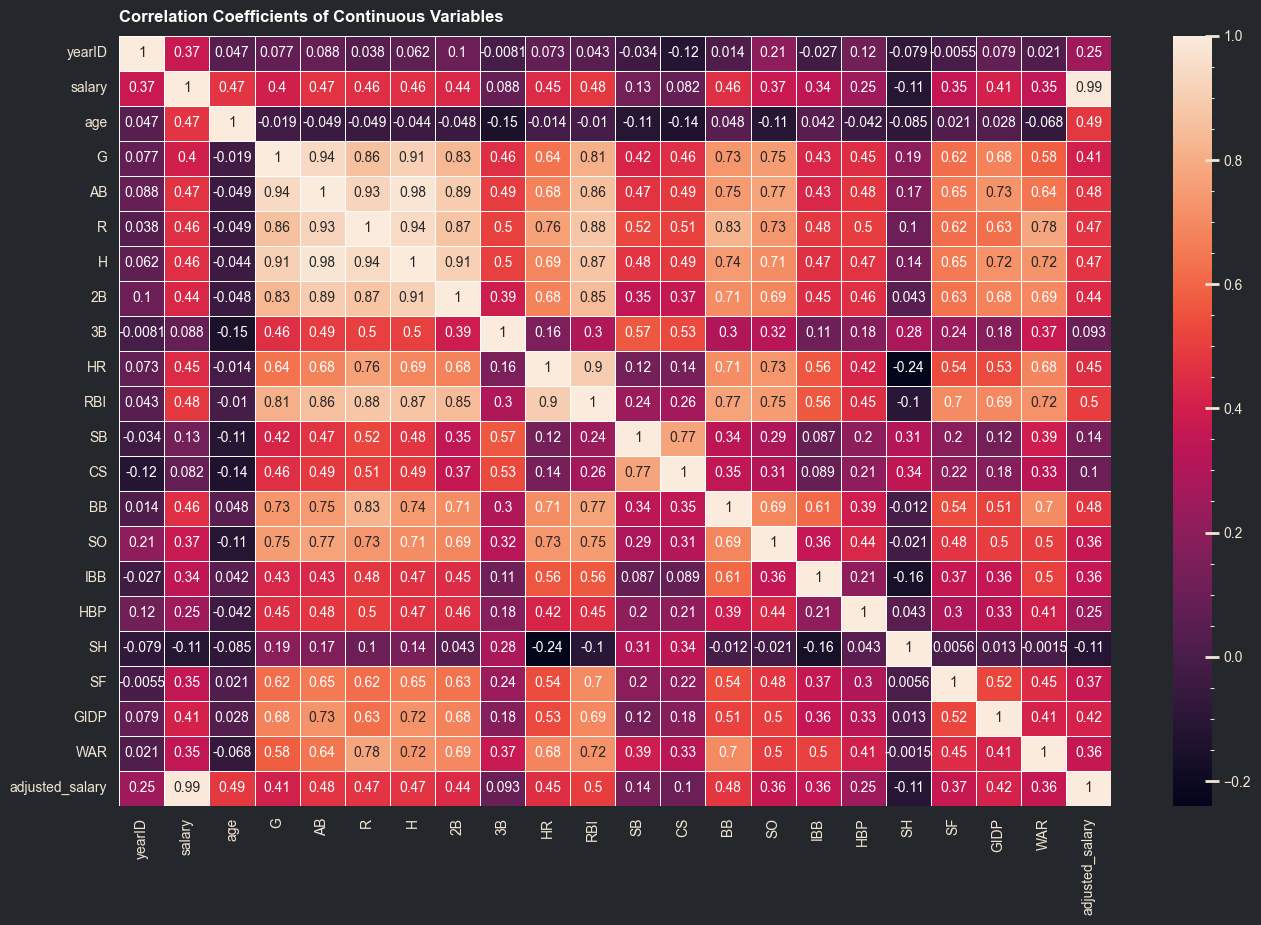

In [24]:
# Plot Correlation Matrix as heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(final_data.corr(numeric_only=True), annot=True, linewidth=.5)
plt.title('Correlation Coefficients of Continuous Variables')
plt.tick_params(left=False, bottom=False, which='both')
plt.grid(visible=False, which='both')
plt.show()

It seems like columns such as `age`, `AB`, `R`, `H`, `HR`, `RBI`, `BB` are all moderately correlated with `salary` with correlation values larger than 0.45, with `RBI` having the largest. Columns `3B` and `CS` have almost no correlation with salary and `SB` and `SH` have very little. It makes sense that `3B`, `SH`, and `CS` have very little impact on player salaries since these not very common occurences with means of 1.93, 2.08, and 2.79 respectively, but I was surprised to see that `SB` has such a low correlation value.

We can see that all columns except for `yearID` seem to have a higher correlation with `adjusted_salary`, which makes sense so hopefully this will indeed make our models better at predicting.

### Salary Distribution

Before doing any exploration between our variables, lets look at the distribution of our dependent variable `salary` and `adjusted_salary`:

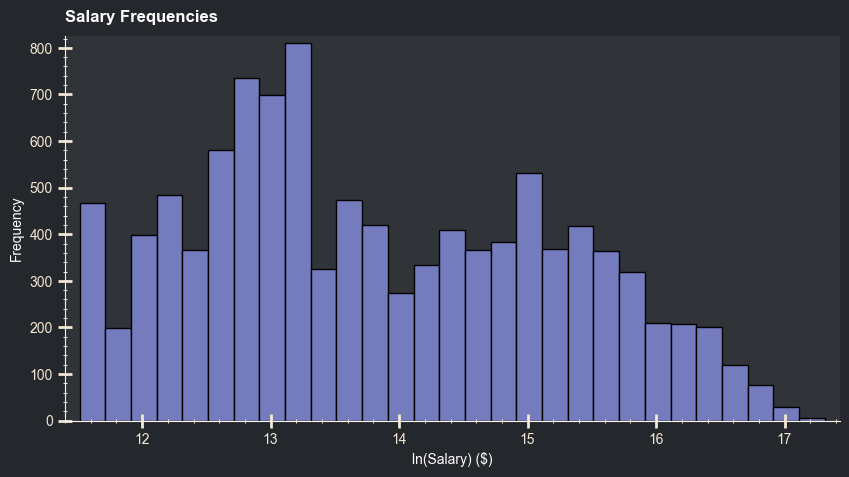

In [25]:
# Plot salary distribution on histogram
plt.figure(figsize=(10,5))
sns.histplot(data=final_data, x='salary')
plt.xlabel('ln(Salary) ($)')
plt.ylabel('Frequency')
plt.title('Salary Frequencies')
plt.grid(visible=False, which='both')
plt.show()

The possible salaries range from $e^{11.5}$ or $98715 and $e^{17.3}$ or $32605775. Our log transform clearly fixed much of skewness of our data, but you can still see that most of the salaries are between $e^{12}$ or $162754 and $e^{14}$ or $1202604 with a peak around $e^{13.2}$ or $540364.

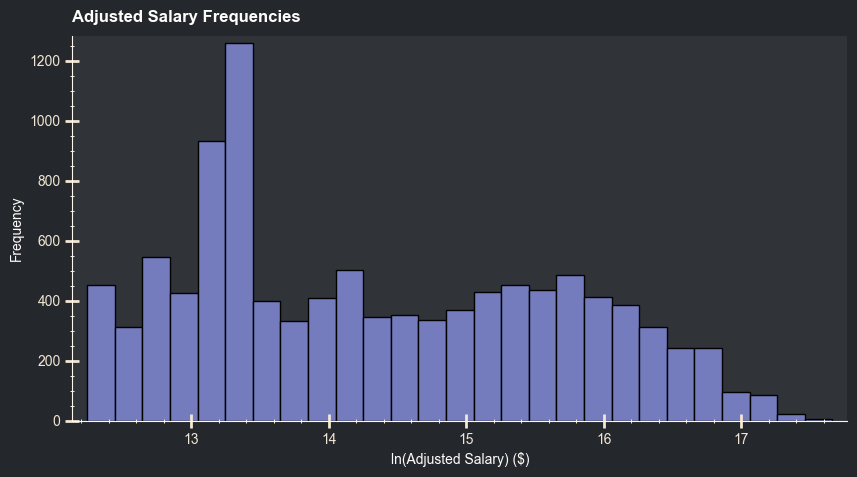

In [26]:
# Plot adjusted salary distribution on histogram
plt.figure(figsize=(10,5))
sns.histplot(data=final_data, x='adjusted_salary')
plt.xlabel('ln(Adjusted Salary) ($)')
plt.ylabel('Frequency')
plt.title('Adjusted Salary Frequencies')
plt.grid(visible=False, which='both')
plt.show()

This distribution seems to make a lot more sense when considering how sports salaries typically are. As we can see most players have a low to moderate salary in comparison to the total range with most players having a salary between $e^{13}$ or $442413 and $e^{13.4}$ or $660003. We can see that there is still a pretty constant rate of players with salaries larger than this, up to around $e^{17}$ or $24154952.

### Mean Salary per Year

Let's take a look at how the mean salaries change each year:

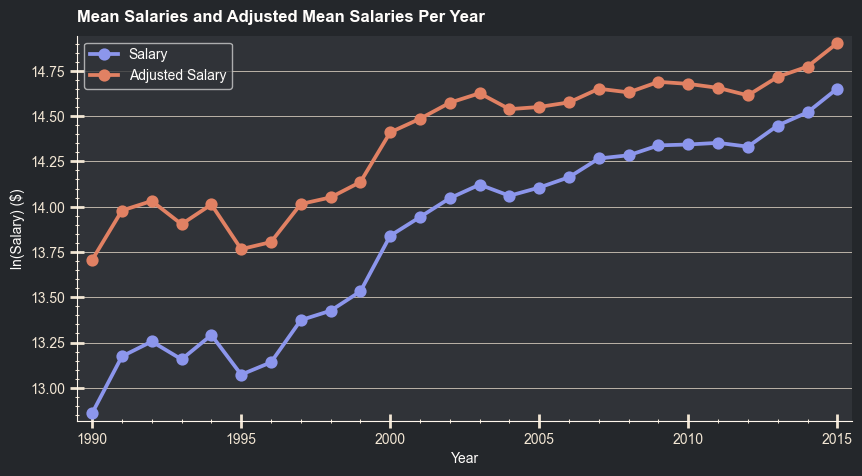

In [27]:
# Calculate mean salaries and mean adjusted salaries per year
mean_salaries = final_data.groupby(by=['yearID'])['salary'].mean().reset_index()
adjusted_mean_salaries = final_data.groupby(by=['yearID'])['adjusted_salary'].mean().reset_index()

# Plot both versions of salaries per year
plt.figure(figsize=(10,5))
sns.pointplot(data=mean_salaries, x='yearID', y='salary', label='Salary')
sns.pointplot(data=adjusted_mean_salaries, x='yearID', y='adjusted_salary', label='Adjusted Salary')
plt.xlabel('Year')
plt.ylabel('ln(Salary) ($)')
plt.title('Mean Salaries and Adjusted Mean Salaries Per Year')
plt.xticks(ticks=[0, 5, 10, 15, 20, 25])
plt.legend()
plt.show()

As you can see, the salaries seem to increase as the years go by which makes sense, considering inflation, but when we look at the adjusted salaries, they still seem to go up each year. I didn't really consider the fact that teams likely became much better at making money through expanding their brand as the years go on, so they were also able to pay players more, even with their salaries adjusted for inflation.

### Mean Salary per Year by League

Now let's look at how each league compares salary wise each year:

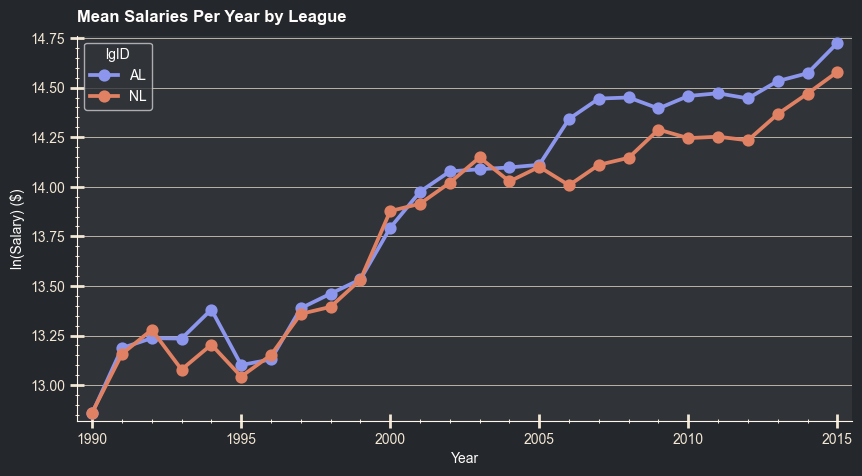

In [28]:
# Calaculate mean salary per year per league
mean_salaries_lg = final_data.groupby(by=['yearID', 'lgID'], observed=False)['salary'].mean().reset_index()

# Plot each league's mean salary per year
plt.figure(figsize=(10,5))
sns.pointplot(data=mean_salaries_lg, x='yearID', y='salary', hue='lgID')
plt.xlabel('Year')
plt.ylabel('ln(Salary) ($)')
plt.title('Mean Salaries Per Year by League')
plt.xticks(ticks=[0, 5, 10, 15, 20, 25])
plt.show()

It seems like both leagues are very similar when it comes to salaries, with the AL being slightly higher post 2005. Based off this graph I am not going to include the `lgID` as a feature when running the models since it likely won't make a big difference.

Let's now take a look at how the salary changes compared to some of our highest correlated columns `age`, `RBI`, `HR`, and `BB`:

### Age Compared to Salaries

First, we will see how a player's age changes their salary:

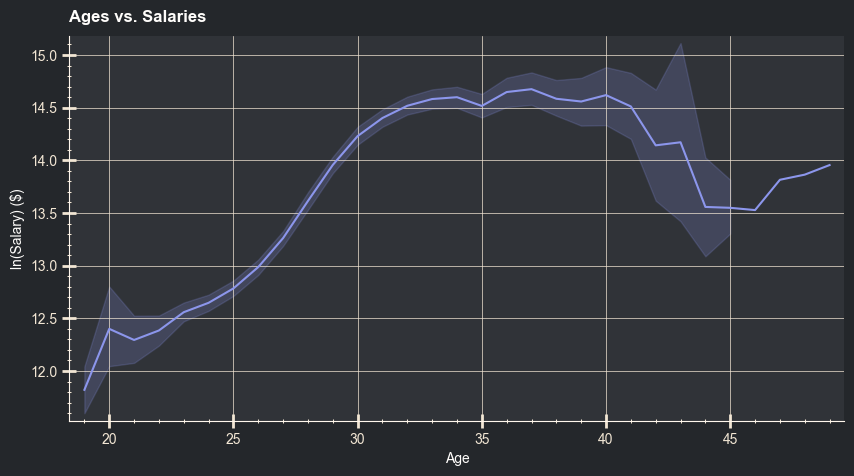

In [29]:
# Plot age compared to salaries
plt.figure(figsize=(10,5))
sns.lineplot(data=final_data, x='age', y='salary')
plt.xlabel('Age')
plt.ylabel('ln(Salary) ($)')
plt.title('Ages vs. Salaries')
plt.show()

This graph looks as expected, the youngest players are typically making the least amount of money because they are rookies often looking for whatever contract they can get to make a name for themselves, with some exceptions of course. As the players get older they get better as they have more playing time and experience, which seems to plateau around 33 years old, until it starts to decline at around 41 years old. Another reason the younger players are making less money is because they likely locked in to contracts when they were drafted, and cannot make more money until they hit free agency after a few years. Although an MLB player's peak salary is around age 30-40, it is well known that the prime batting age is around 25-30 years old, which we can see in the graph below:

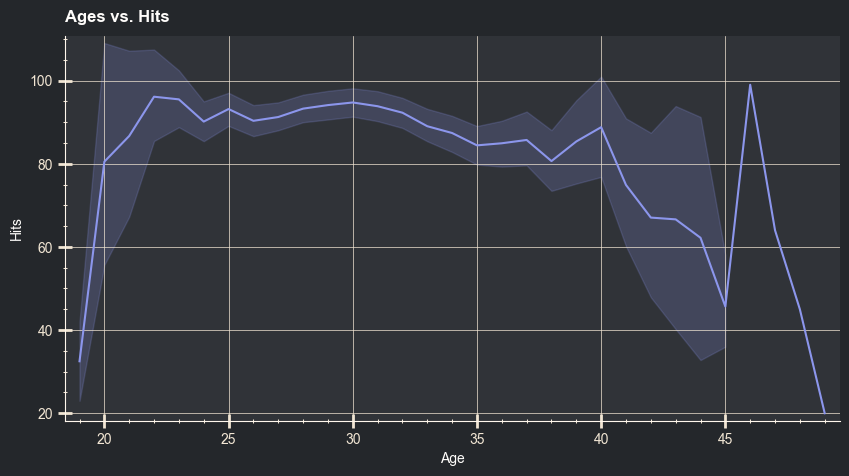

In [30]:
# Plot age compared to hits
plt.figure(figsize=(10,5))
sns.lineplot(data=final_data, x='age', y='H')
plt.xlabel('Age')
plt.ylabel('Hits')
plt.title('Ages vs. Hits')
plt.show()

According to the graph, players are best at hitting between the ages 22-30, and then start to slowly decline from 30-40, with a harsh decline as they continue to get older. As you can see, there is an outlier at around age 46, this is likely just a singular player who was still playing for that long because they were a genetic exception still batting great.

### RBI Compared to Salaries

Now let's look at our next variable `RBI`:

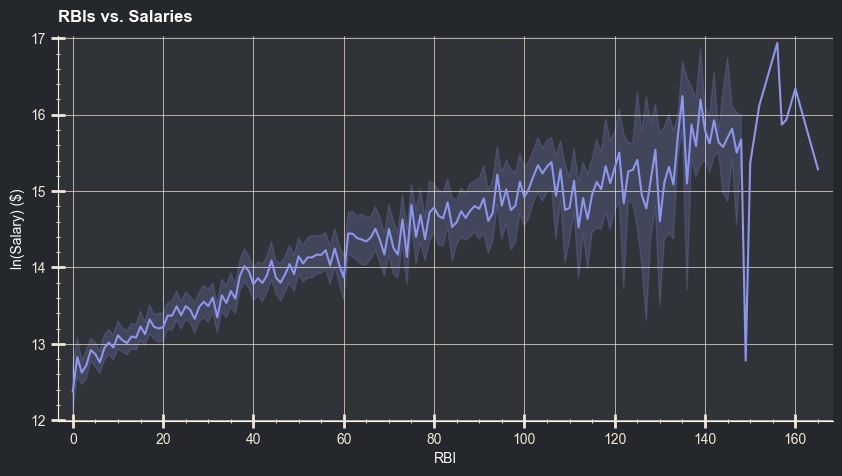

In [31]:
# Plot RBI compared to salary
plt.figure(figsize=(10,5))
sns.lineplot(data=final_data, x='RBI', y='salary')
plt.xlabel('RBI')
plt.ylabel('ln(Salary) ($)')
plt.title('RBIs vs. Salaries')
plt.show()

### HR Compared to Salaries

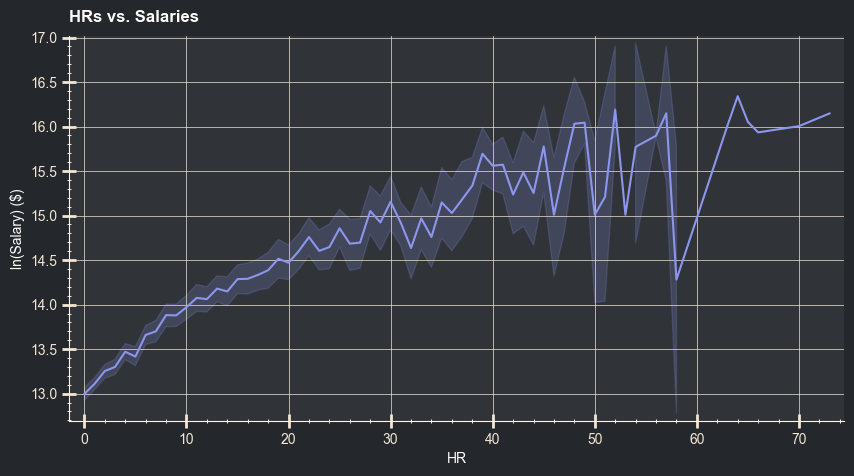

In [32]:
# Plot HR compared to salary
plt.figure(figsize=(10,5))
sns.lineplot(data=final_data, x='HR', y='salary')
plt.xlabel('HR')
plt.ylabel('ln(Salary) ($)')
plt.title('HRs vs. Salaries')
plt.show()

### BB Compared to Salaries

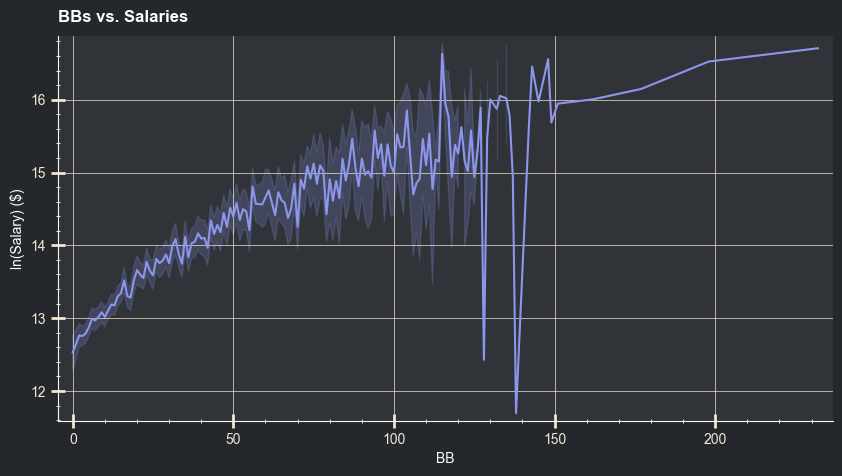

In [33]:
# Plot BB compared to salary
plt.figure(figsize=(10,5))
sns.lineplot(data=final_data, x='BB', y='salary')
plt.xlabel('BB')
plt.ylabel('ln(Salary) ($)')
plt.title('BBs vs. Salaries')
plt.show()

### Positions Compared to Salaries

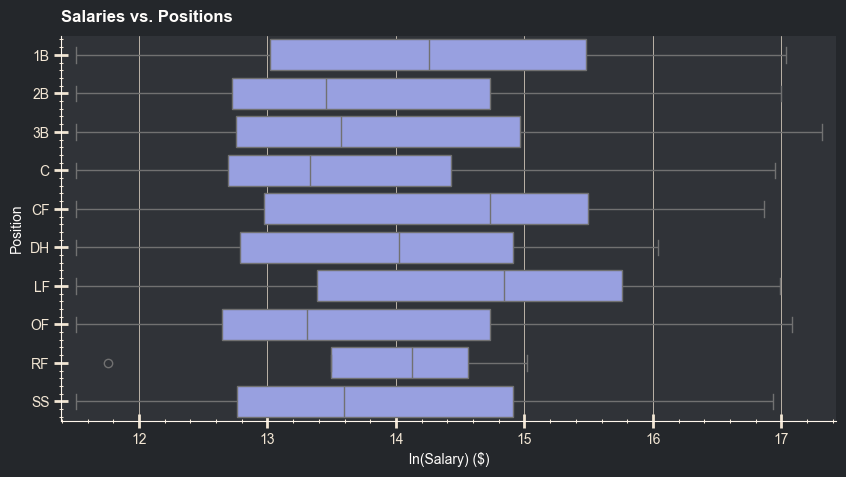

In [34]:
plt.figure(figsize=(10,5))
sns.boxplot(data=final_data, x='salary', y='POS')
plt.xlabel('ln(Salary) ($)')
plt.ylabel('Position')
plt.title('Salaries vs. Positions')
plt.show()

### Mean Salaries per Year by Position

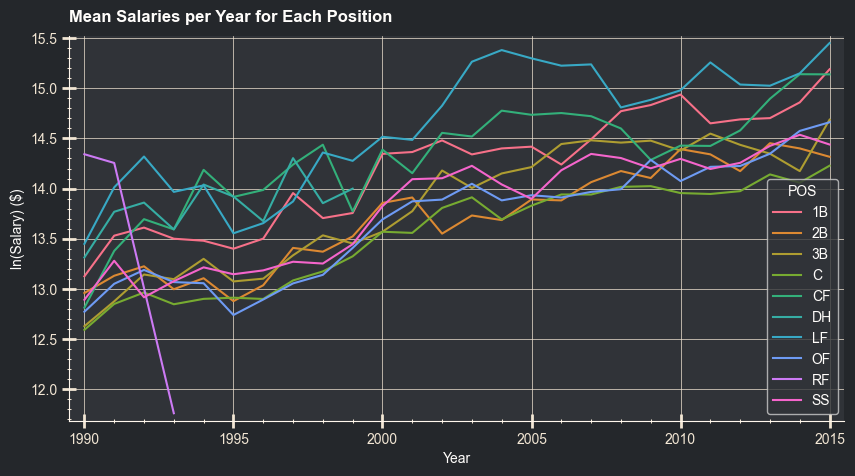

In [35]:
mean_salaries_pos = final_data.groupby(by=['yearID', 'POS'], observed=True)['salary'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=mean_salaries_pos, x='yearID', y='salary', hue='POS')
plt.xlabel('Year')
plt.ylabel('ln(Salary) ($)')
plt.title('Mean Salaries per Year for Each Position')
plt.show()

---
## Setting up for our Models

Before we can start fitting the models, we must first do some set-up. We can now remove columns like `nameFull` and `playerID` since they won't help in the predictions and were purely used for data cleaning. 

In [ ]:
# Split up our feature and prediction column names
features = ['yearID','age','POS','AB','R','H','2B','3B','HR','RBI','SB','CS','BB','SO','IBB','HBP','SH','SF','GIDP', 'WAR']
predictor = ['salary', 'adjusted_salary']

# Finalize our final dataset
final_data = final_data[features + predictor]

### Data Split

Now before we continue with fitting our models, we need to split our data into a training and testing set. We will use our training set to fit our models, and once they are fit we will see how they perform on our testing set. We split the data to ensure that our models aren't overfitting, because we might be given "good" values for metrics such as RMSE and $R^2$ on our traning data, but these same models might perform poorly on testing data. To determine our best model I will be using RMSE (root mean squared error) so whichever model gives us the lowest RMSE from our testing data will be the best. I will be using a 80/20 split, so 80% of our data is going to the training set and 20% is going to the testing set. I can afford using a lower testing percentage because I have such a large amount of data. This will make our models have more data to train on and hopefully perform better. Finally, I will also be stratifying our data based on our outcome variable, `salary`, to make sure that both the training and testing data have an equal distribution of salaries.

In [ ]:
# Generate our randomstate for reproducibility
rng = np.random.RandomState(50)

# Create bins for salary for stratification
final_data['salary_bins'] = pd.cut(final_data['salary'], bins=10)

# Split the data
train_data, test_data = train_test_split(final_data, test_size=0.2, stratify=final_data['salary_bins'], random_state=rng)

# Split our tranining and testing data to predictors and observations
X_train_data = train_data[features]
X_test_data = test_data[features]
Y_train_data = train_data[predictor]
Y_test_data = test_data[predictor]

### Preprocessing

The final step we have to work on before we create our model pipelines is to do some preprocessing of our data. As shown above, we have narrowed our features down to the following: `yearID`, `age`, `AB`, `R`, `H`, `2B`, `3B`, `HR`, `RBI`, `SB`, `CS`, `BB`, `SO`, `IBB`, `HBP`, `SH`, `SF`, `GIDP`, `WAR`, and `POS`. I decided not to include `lgID` because the salaries are very similar for both leagues and we aren't using `teamID` because it will introduce way too many features after it is dummy encoded. For our numerical features, or all the features except `POS`, we will be normalizing all values which makes the mean 0 and standard deviation 1. This ensures that all features have values with the same scaling to ensure that those with typically large values don't have more weight than features will small values. For our categorical feature, `POS`, we will be dummy encoding it, so it will create a new feature for each unique value in `POS`, in which observations are given a value of 1 if they have that classification, and 0 if they do not.

We will also be performing K-fold cross validation on all our data when we perform the gridsearch for hyperparameters later on. This will create k new identical sets of data, based on what we set the value to be, with 1/k of that set saved for cross-validation testing when choosing different hyperparamters. Each split has all unique data from our full dataset to test from. Based on the metric we choose, each of the k folds will output how our models do for each set of hyperparameters we are testing. I arbitrarily picked 5 folds because it provides around 20% of our data for the cross-validation which should be enough given our large amount of data.

In [38]:
# Split up our numerical and categorical feature names
numerical_features = ['yearID','age','AB','R','H','2B','3B','HR','RBI','SB','CS','BB','SO','IBB','HBP','SH','SF','GIDP', 'WAR']
categorical_features = ['POS']

# Create preprocessor for numerical and categorical features
preprocessor = ColumnTransformer(transformers=[('numerical', StandardScaler(), numerical_features),
                                               ('categorical', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)],
                                verbose_feature_names_out=False)

# Set up the k-folds for cross-validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=rng)

---
## Model Building

Its now time to build our pipelines that contain all our models and preprocessing steps. After the pipeline runs the preprocessing described above, I decided to also add a function that selects the k best features based on an f test for a linear regression model. The values we will be using for k will be added to our hyperparameter gridsearch, so we can see how all our models perform with varying amounts of features. As for the models themselves, I will be using linear regression, lasso regression, elastic net, k-nearest neighbors, random forest, xgboost, and a multi-layer perceptron. As I said earlier, to determine the best model I will be calculating the RMSE 

In [39]:
# Create the Linear Regression pipeline
lr_pipeline = Pipeline(steps=[('preprocessor',  preprocessor),
                              ('feature_selection', SelectKBest(score_func=f_regression)),
                              ('model', LinearRegression())])

# Create the Lasso Regression pipeline
lsr_pipeline = Pipeline(steps=[('preprocessor',  preprocessor),
                              ('feature_selection', SelectKBest(score_func=f_regression)),
                              ('model', Lasso(random_state=rng))])

# Create the Elastic Net pipeline
e_net_pipeline = Pipeline(steps=[('preprocessor',  preprocessor),
                              ('feature_selection', SelectKBest(score_func=f_regression)),
                              ('model', ElasticNet(random_state=rng))])

# Create the K-Nearest Neighbors pipeline
knn_pipeline = Pipeline(steps=[('preprocessor',  preprocessor),
                              ('feature_selection', SelectKBest(score_func=f_regression)),
                              ('model', KNeighborsRegressor())])

# Create the Random Forest pipeline
rf_pipeline = Pipeline(steps=[('preprocessor',  preprocessor),
                              ('feature_selection', SelectKBest(score_func=f_regression)),
                              ('model', RandomForestRegressor(random_state=rng))])

# Create the XGBoost pipeline
xgb_pipeline = Pipeline(steps=[('preprocessor',  preprocessor),
                              ('feature_selection', SelectKBest(score_func=f_regression)),
                              ('model', XGBRegressor(random_state=rng, objective='reg:squarederror', eval_metric='rmse'))])

# Create the Neural Network pipeline
nn_pipeline = Pipeline(steps=[('preprocessor',  preprocessor),
                              ('feature_selection', SelectKBest(score_func=f_regression)),
                              ('model', MLPRegressor(max_iter=1000, random_state=rng))])

Now set up hyperparameter grids for when we perform gridsearch

In [40]:
# Linear Regression parameter grid
lr_params = {'feature_selection__k' : [15, 20, 25]}

# Lasso Regression parameter grid
lsr_params = {'feature_selection__k' : [15, 20, 25],
              'model__alpha' : [.0001, .001, .01, .1, .25]}

# Elastic Net parameter grid
e_net_params = {'feature_selection__k' : [15, 20, 25],
                'model__alpha' : [.0001, .001, .01, .1, .25],
                'model__l1_ratio' : np.linspace(0.2, 1, 5)}

# K-Nearest Neighbors parameter grid
knn_params = {'feature_selection__k' : [15, 20, 25],
              'model__n_neighbors' : np.linspace(5, 25, 5, dtype='int')}

# Random Forest parameter grid
rf_params = [{'feature_selection__k' : [15],
             'model__n_estimators' : np.linspace(200, 1000, 5, dtype='int'),
             'model__max_features' : np.linspace(3, 15, 5, dtype='int')},
             {'feature_selection__k' : [20],
             'model__n_estimators' : np.linspace(200, 1000, 5, dtype='int'),
             'model__max_features' : np.linspace(4, 20, 5, dtype='int')},
             {'feature_selection__k' : [25],
             'model__n_estimators' : np.linspace(200, 1000, 5, dtype='int'),
             'model__max_features' : np.linspace(5, 25, 5, dtype='int')}]

# XGBoost parameter grid
xgb_params = {'feature_selection__k' : [15, 20, 25],
              'model__n_estimators' : np.linspace(600, 1000, 5, dtype='int'),
             'model__max_depth' : np.linspace(2, 10, 5, dtype='int'),
             'model__learning_rate' : [.01, .025, .05, .075]}

# Neural Network parameter grid
nn_params = {'feature_selection__k' : [15, 20, 25],
             'model__hidden_layer_sizes' : [(25,), (50,), (100,), (100, 50), (50, 25)],
             'model__alpha' : [.0001, .001, .01],
             'model__learning_rate_init' : [.0001, .0001, .001, .01]}

Now create each gridsearch.

In [41]:
lr_gridsearch = GridSearchCV(estimator=lr_pipeline, param_grid=lr_params, cv=k_fold, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=3, error_score='raise')

lsr_gridsearch = GridSearchCV(estimator=lsr_pipeline, param_grid=lsr_params, cv=k_fold, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=3, error_score='raise')

e_net_gridsearch = GridSearchCV(estimator=e_net_pipeline, param_grid=e_net_params, cv=k_fold, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=3, error_score='raise')

knn_gridsearch = GridSearchCV(estimator=knn_pipeline, param_grid=knn_params, cv=k_fold, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=3, error_score='raise')

rf_gridsearch = GridSearchCV(estimator=rf_pipeline, param_grid=rf_params, cv=k_fold, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=3, error_score='raise')

xgb_gridsearch = GridSearchCV(estimator=xgb_pipeline, param_grid=xgb_params, cv=k_fold, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=3, error_score='raise')

nn_gridsearch = GridSearchCV(estimator=nn_pipeline, param_grid=nn_params, cv=k_fold, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=3, error_score='raise')

Fit all the models.

In [42]:
# lr_gridsearch.fit(X_train_data, np.ravel(Y_train_data['salary']))

# lsr_gridsearch.fit(X_train_data, np.ravel(Y_train_data['salary']))

# e_net_gridsearch.fit(X_train_data, np.ravel(Y_train_data['salary']))

# knn_gridsearch.fit(X_train_data, np.ravel(Y_train_data['salary']))

# rf_gridsearch.fit(X_train_data, np.ravel(Y_train_data['salary']))

# xgb_gridsearch.fit(X_train_data, np.ravel(Y_train_data['salary']))

# nn_gridsearch.fit(X_train_data, np.ravel(Y_train_data['salary']))

Save our models.

In [43]:
# joblib.dump(lr_gridsearch, 'lr_model.pkl')

# joblib.dump(lsr_gridsearch, 'lsr_model.pkl')

# joblib.dump(e_net_gridsearch, 'e_net_model.pkl')

# joblib.dump(knn_gridsearch, 'knn_model.pkl')

# joblib.dump(rf_gridsearch, 'rf_model.pkl')

# joblib.dump(xgb_gridsearch, 'xgb_model.pkl')

# joblib.dump(nn_gridsearch, 'nn_model.pkl')

In [44]:
# joblib.dump(lr_gridsearch, 'lr_model_adjusted.pkl')

# joblib.dump(lsr_gridsearch, 'lsr_model_adjusted.pkl')

# joblib.dump(e_net_gridsearch, 'e_net_model_adjusted.pkl')

# joblib.dump(knn_gridsearch, 'knn_model_adjusted.pkl')

# joblib.dump(rf_gridsearch, 'rf_model_adjusted.pkl')

# joblib.dump(xgb_gridsearch, 'xgb_model_adjusted.pkl')

# joblib.dump(nn_gridsearch, 'nn_model_adjusted.pkl')

Load the models.

In [45]:
lr_model = joblib.load('lr_model.pkl')

lsr_model = joblib.load('lsr_model.pkl')

e_net_model = joblib.load('e_net_model.pkl')

knn_model = joblib.load('knn_model.pkl')

rf_model = joblib.load('rf_model.pkl')

xgb_model = joblib.load('xgb_model.pkl')

nn_model = joblib.load('nn_model.pkl')

In [46]:
lr_model_adjusted = joblib.load('lr_model_adjusted.pkl')

lsr_model_adjusted = joblib.load('lsr_model_adjusted.pkl')

e_net_model_adjusted = joblib.load('e_net_model_adjusted.pkl')

knn_model_adjusted = joblib.load('knn_model_adjusted.pkl')

rf_model_adjusted = joblib.load('rf_model_adjusted.pkl')

xgb_model_adjusted = joblib.load('xgb_model_adjusted.pkl')

nn_model_adjusted = joblib.load('nn_model_adjusted.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'lr_model_adjusted.pkl'

---
## Model Results

In [47]:
Y_test_normal = Y_test_data['salary']

model_results = pd.DataFrame({'Model' : ['Linear Regression', 'Lasso Regression', 'Elastic Net', 'K-Nearest Neighbors', 'Random Forest', 'XGBoost', 'Neural Network'],
                              'RMSE' : [-lr_model.best_score_, -lsr_model.best_score_, -e_net_model.best_score_, -knn_model.best_score_, -rf_model.best_score_, -xgb_model.best_score_, -nn_model.best_score_],
                              'Test RMSE' : [np.sqrt(mean_squared_error(lr_model.predict(X_test_data), Y_test_normal)), np.sqrt(mean_squared_error(lsr_model.predict(X_test_data), Y_test_normal)), np.sqrt(mean_squared_error(e_net_model.predict(X_test_data), Y_test_normal)),
                                             np.sqrt(mean_squared_error(knn_model.predict(X_test_data), Y_test_normal)), np.sqrt(mean_squared_error(rf_model.predict(X_test_data), Y_test_normal)), np.sqrt(mean_squared_error(xgb_model.predict(X_test_data), Y_test_normal)),
                                             np.sqrt(mean_squared_error(nn_model.predict(X_test_data), Y_test_normal))],
                              'Test R2' : [r2_score(y_pred=lr_model.predict(X_test_data), y_true=Y_test_normal), r2_score(y_pred=lsr_model.predict(X_test_data), y_true=Y_test_normal), r2_score(y_pred=e_net_model.predict(X_test_data), y_true=Y_test_normal),
                                           r2_score(y_pred=knn_model.predict(X_test_data), y_true=Y_test_normal), r2_score(y_pred=rf_model.predict(X_test_data), y_true=Y_test_normal), r2_score(y_pred=xgb_model.predict(X_test_data), y_true=Y_test_normal),
                                           r2_score(y_pred=nn_model.predict(X_test_data), y_true=Y_test_normal)]})
model_results

ValueError: columns are missing: {'war'}

In [314]:
Y_test_adjusted = Y_test_data['adjusted_salary']

model_results = pd.DataFrame({'Model' : ['Linear Regression', 'Lasso Regression', 'Elastic Net', 'K-Nearest Neighbors', 'Random Forest', 'XGBoost', 'Neural Network'],
                              'RMSE' : [-lr_model_adjusted.best_score_, -lsr_model_adjusted.best_score_, -e_net_model_adjusted.best_score_, -knn_model_adjusted.best_score_, -rf_model_adjusted.best_score_, -xgb_model_adjusted.best_score_, -nn_model_adjusted.best_score_],
                              'Test RMSE' : [np.sqrt(mean_squared_error(lr_model_adjusted.predict(X_test_data), Y_test_adjusted)), np.sqrt(mean_squared_error(lsr_model_adjusted.predict(X_test_data), Y_test_adjusted)), np.sqrt(mean_squared_error(e_net_model_adjusted.predict(X_test_data), Y_test_adjusted)),
                                             np.sqrt(mean_squared_error(knn_model_adjusted.predict(X_test_data), Y_test_adjusted)), np.sqrt(mean_squared_error(rf_model_adjusted.predict(X_test_data), Y_test_adjusted)), np.sqrt(mean_squared_error(xgb_model_adjusted.predict(X_test_data), Y_test_adjusted)),
                                             np.sqrt(mean_squared_error(nn_model_adjusted.predict(X_test_data), Y_test_adjusted))],
                              'Test R2' : [r2_score(y_pred=lr_model_adjusted.predict(X_test_data), y_true=Y_test_adjusted), r2_score(y_pred=lsr_model_adjusted.predict(X_test_data), y_true=Y_test_adjusted), r2_score(y_pred=e_net_model_adjusted.predict(X_test_data), y_true=Y_test_adjusted),
                                           r2_score(y_pred=knn_model_adjusted.predict(X_test_data), y_true=Y_test_adjusted), r2_score(y_pred=rf_model_adjusted.predict(X_test_data), y_true=Y_test_adjusted), r2_score(y_pred=xgb_model_adjusted.predict(X_test_data), y_true=Y_test_adjusted),
                                           r2_score(y_pred=nn_model_adjusted.predict(X_test_data), y_true=Y_test_adjusted)]})
model_results

,Model,RMSE,Test RMSE,Test R2
0,Linear Regression,0.856323,0.887790,0.550639
1,Lasso Regression,0.857851,0.887844,0.550584
2,Elastic Net,0.856302,0.887836,0.550592
3,K-Nearest Neighbors,0.852429,0.876774,0.561721
4,Random Forest,0.798441,0.818196,0.618329
5,XGBoost,0.780071,0.809714,0.626201
6,Neural Network,0.796253,0.809036,0.626827


In [389]:
pd.DataFrame(xgb_model.cv_results_).sort_values(by='rank_test_score', axis=0).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_feature_selection__k,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
230,0.668754,0.036636,0.030377,0.007188,25,0.025,4,600,"{'feature_selection__k': 25, 'model__learning_...",-0.785811,-0.770270,-0.785540,-0.770079,-0.771231,-0.776586,0.007432,1
231,0.764480,0.049935,0.027160,0.002579,25,0.025,4,700,"{'feature_selection__k': 25, 'model__learning_...",-0.785753,-0.770125,-0.786675,-0.768879,-0.771764,-0.776639,0.007877,2
232,0.826478,0.038313,0.042653,0.007491,25,0.025,4,800,"{'feature_selection__k': 25, 'model__learning_...",-0.786041,-0.769931,-0.786830,-0.768601,-0.771851,-0.776651,0.008060,3
233,0.896834,0.042434,0.046240,0.005305,25,0.025,4,900,"{'feature_selection__k': 25, 'model__learning_...",-0.785429,-0.770656,-0.787245,-0.769315,-0.773138,-0.777157,0.007617,4
234,1.024573,0.037907,0.057092,0.005667,25,0.025,4,1000,"{'feature_selection__k': 25, 'model__learning_...",-0.785089,-0.771348,-0.788051,-0.769441,-0.773736,-0.777533,0.007561,5


In [382]:
pd.DataFrame(nn_model_adjusted.cv_results_).sort_values(by='rank_test_score', axis=0).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_feature_selection__k,param_model__alpha,param_model__hidden_layer_sizes,param_model__learning_rate_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
131,11.129211,0.586166,0.003004,0.000841,25,0.0100,"(100,)",0.0001,"{'feature_selection__k': 25, 'model__alpha': 0...",-0.787734,-0.826888,-0.809506,-0.784035,-0.773105,-0.796253,0.019349,1
101,12.845886,0.778755,0.005319,0.001166,25,0.0001,"(100,)",0.0001,"{'feature_selection__k': 25, 'model__alpha': 0...",-0.787329,-0.827559,-0.810552,-0.783757,-0.773224,-0.796484,0.019750,2
116,12.461799,0.964665,0.004418,0.000210,25,0.0010,"(100,)",0.0001,"{'feature_selection__k': 25, 'model__alpha': 0...",-0.787572,-0.827637,-0.810485,-0.783683,-0.773682,-0.796612,0.019645,3
122,2.454644,0.265370,0.004104,0.000204,25,0.0100,"(25,)",0.0010,"{'feature_selection__k': 25, 'model__alpha': 0...",-0.780495,-0.824071,-0.822212,-0.784199,-0.774604,-0.797116,0.021477,4
92,2.509044,0.296357,0.004509,0.001767,25,0.0001,"(25,)",0.0010,"{'feature_selection__k': 25, 'model__alpha': 0...",-0.781943,-0.824347,-0.823154,-0.784789,-0.774951,-0.797837,0.021402,5


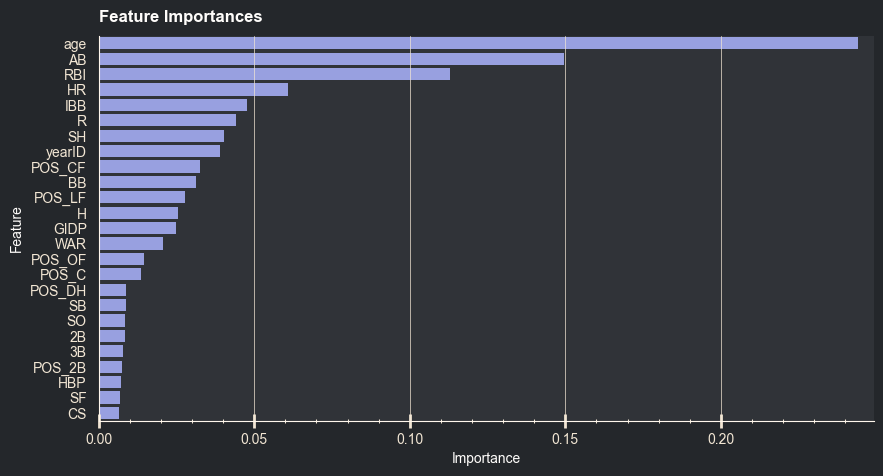

In [285]:
best_xgb = xgb_model_adjusted.best_estimator_

# Get feature importances and names for our plot
feature_importances = best_xgb.named_steps['model'].feature_importances_
feature_names = best_xgb.named_steps['preprocessor'].get_feature_names_out()[best_xgb.named_steps['feature_selection'].get_support()]

# Create a data frame for our feature importance and names
importance_df = pd.DataFrame({
    'Feature' : feature_names,
    'Importance' : feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot all feature importances
plt.figure(figsize=(10,5))
sns.barplot(data=importance_df, x='Importance', y='Feature', orient='h')
plt.tick_params(left=False, which='both')
plt.title('Feature Importances')
plt.show()

In [410]:
player = pd.DataFrame({'yearID' : [2017, 2022],
                       'age' : [29, 30],
                       'POS' : ['1B', 'OF'],
                       'AB' : [382, 570],
                       'R' : [63, 133],
                       'H' : [92, 177],
                       '2B' : [27, 28],
                       '3B' : [3, 0],
                       'HR' : [18, 62],
                       'RBI' : [51, 131],
                       'SB' : [3, 16],
                       'CS' : [2, 3],
                       'BB' : [66, 111],
                       'SO' : [104, 175],
                       'IBB' : [2, 19],
                       'HBP' : [2, 6],
                       'SH' : [0, 0],
                       'SF' : [1, 5],
                       'GIDP' : [5, 14],
                       'WAR' : [2.8, 10.5]})
print(np.exp(xgb_model.best_estimator_.predict(player)))

[ 2960654.2 12272765. ]


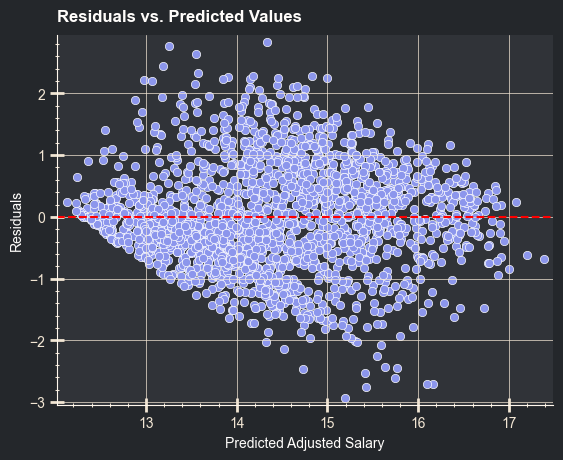

In [408]:
Y_pred_xgb = nn_model_adjusted.predict(X_test_data)

residuals = Y_test_adjusted - Y_pred_xgb
sns.scatterplot(x=Y_pred_xgb, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Adjusted Salary')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

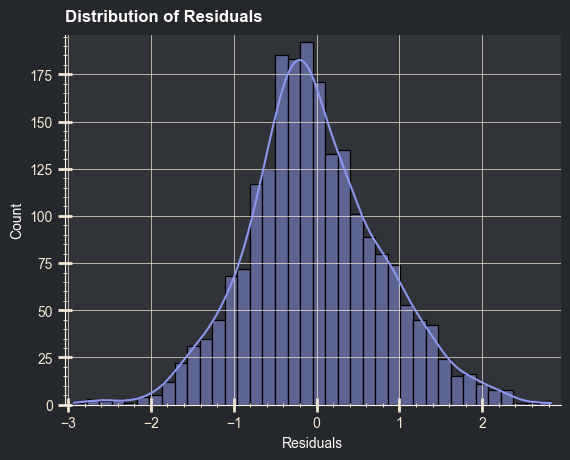

In [409]:
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()